# First Steps with Feedback Control

**WARNING:** Some cells in this notebook are not meant to be run sequentially!

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline  
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [15]:
from ctrl.block.linear import TransferFunction, Gain, Feedback
from ctrl.system.tf import PID
from ctrl.block.logger import Logger
from ctrl.block.nl import DeadZone

Substitute `HOST` and `PORT` with the IP address and port of your controller:

In [16]:
from ctrl.client import Controller
HOST, PORT = "192.168.10.102", 9999
controller = Controller(host = HOST, port = PORT)

In [17]:
controller.reset()
controller.add_signals('reference1','deadzoneinverse')
controller.add_sink('logger', Logger(), 
                    ['clock', 'encoder1','motor1','reference1','theta'])

In [18]:
print(controller.info('all'))

> Controller with 7 signal(s), 4 source(s), 2 sink(s), and 0 filter(s)
> period = 0.01s
> signals
  1. encoder1
  2. clock
  3. pot1
  4. motor1
  5. reference1
  6. theta
  7. deadzoneinverse
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. pot1[enabled] >> pot1
  4. inclinometer1[enabled] >> theta
> filters
> sinks
  1. motor1 >> motor1[enabled]
  2. clock, encoder1, motor1, reference1, theta >> logger[enabled]



#Closed loop on $\phi$ (Down)

In [155]:
pmax = 1
Kp = 3*100
Kd = 0
Ki = 6*100

try:
    controller.remove_filter('controller1')
    controller.remove_filter('deadzoneinverse')
except:
    pass
controller.add_filter('controller1', 
                      Feedback(gamma = pmax,
                               block = TransferFunction(model = PID(Kp = Kp, Kd = Kd, Ki = Ki, period = controller.period))),
                      ['encoder1', 'reference1'], 
                      ['deadzoneinverse'])
controller.add_filter('deadzoneinverse', 
                      DeadZone(Y = 11, X = 1),
                      ['deadzoneinverse'], 
                      ['motor1'])
print(controller.info('all'))

> Controller with 7 signal(s), 4 source(s), 2 sink(s), and 2 filter(s)
> period = 0.01s
> signals
  1. encoder1
  2. clock
  3. pot1
  4. motor1
  5. reference1
  6. theta
  7. deadzoneinverse
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. pot1[enabled] >> pot1
  4. inclinometer1[enabled] >> theta
> filters
  1. encoder1, reference1 >> controller1[enabled] >> deadzoneinverse
  2. deadzoneinverse >> deadzoneinverse[enabled] >> motor1
> sinks
  1. motor1 >> motor1[disabled]
  2. clock, encoder1, motor1, reference1, theta >> logger[enabled]



In [58]:
controller.set_source('encoder1',reset=True)

In [156]:
preference = 0/360*100
controller.set_source('clock',reset=True)
controller.set_sink('logger',reset=True)
with controller:
    controller.set_signal('reference1',preference)
    time.sleep(10)
log = controller.read_sink('logger')

In [157]:
t = log[:,0]
position = log[:,1]
control = log[:,2]
reference = log[:,3]
theta = log[:,4]

print(np.mean(theta))

velocity = np.zeros(t.shape, float)
velocity[1:] = (position[1:]-position[:-1])/(t[1:]-t[:-1])

-0.249035650556


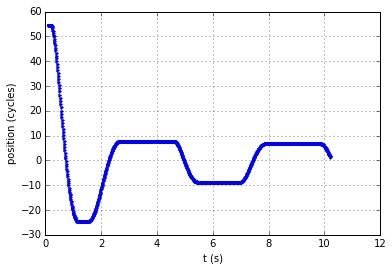

In [158]:
plt.plot(t, 360*position, '.')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

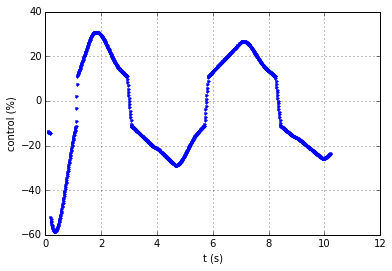

In [159]:
plt.plot(t, control, '.')
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()

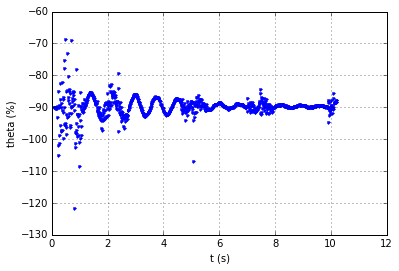

In [160]:
plt.plot(t, 360*theta, '.')
plt.xlabel('t (s)')
plt.ylabel('theta (%)')
plt.grid()

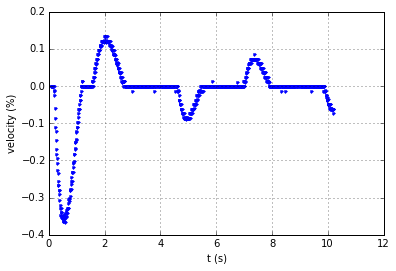

In [161]:
plt.plot(t, velocity, '.')
plt.xlabel('t (s)')
plt.ylabel('velocity (%)')
plt.grid()

#Closed loop on $\theta$ (Down)

In [9]:
pmax = 1
Kp = 4*100
Kd = 0.02*100
Ki = 0*100


try:
    controller.remove_filter('controller1')
except:
    pass
controller.add_filter('controller1', 
                      Feedback(gamma = pmax,
                               block = TransferFunction(model = PID(Kp = Kp, Kd = Kd, Ki = Ki, period = controller.period))),
                      ['theta', 'reference1'], 
                      ['deadzoneinverse'])
print(controller.info('all'))

> Controller with 7 signal(s), 4 source(s), 2 sink(s), and 2 filter(s)
> period = 0.01s
> signals
  1. encoder1
  2. clock
  3. pot1
  4. motor1
  5. reference1
  6. theta
  7. deadzoneinverse
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. pot1[enabled] >> pot1
  4. theta[enabled] >> theta
> filters
  1. deadzoneinverse >> deadzoneinverse[enabled] >> motor1
  2. theta, reference1 >> controller1[enabled] >> deadzoneinverse
> sinks
  1. motor1 >> motor1[disabled]
  2. clock, encoder1, motor1, reference1, theta >> logger[enabled]



In [10]:
preference = 0.25*100
controller.set_sink('logger','reset')
#controller.write_source('encoder1',[0,])
with controller:
    controller.set_signal('reference1',preference)
    time.sleep(10)
log = controller.read_sink('logger')

In [13]:
t = log[:,0]
position = log[:,1]
control = log[:,2]
reference = log[:,3]
theta = log[:,4]

print(np.mean(theta))

velocity = np.zeros(t.shape, float)
velocity[1:] = (position[1:]-position[:-1])/(t[1:]-t[:-1])

0.251945677781


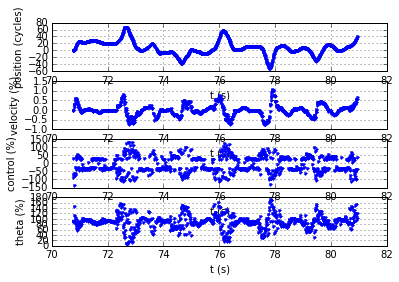

In [14]:
plt.subplot(4,1,1)
plt.plot(t, 360*position, '.')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

plt.subplot(4,1,2)
plt.plot(t, velocity, '.')
plt.xlabel('t (s)')
plt.ylabel('velocity (%)')
plt.grid()

plt.subplot(4,1,3)
plt.plot(t, control, '.')
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()

plt.subplot(4,1,4)
plt.plot(t, 360*theta, '.')
plt.xlabel('t (s)')
plt.ylabel('theta (%)')
plt.grid()

#Control Up TF

In [15]:
pmax = 1
#Kp = 4*100

#12V Large Gear Box
#num = np.array([-80,76.84])
#den = np.array([1,-0.9975])

num = np.array([0,-49.73,135.8,-123.3,37.19])
den = np.array([1,-3.244,3.94,-2.141,0.4454])

#num = np.array([0,-0.002084,0.002114,0.002024,-0.002054])
#den = np.array([1,-4,5.957,-3.914,0.9571])




try:
    controller.remove_filter('controller1')
except:
    pass
controller.add_filter('controller1', 
                      Feedback(gamma = pmax,
                               block = TransferFunction(model = TFModel(num, den))),
                      ['theta', 'reference1'], 
                      ['deadzoneinverse'])
print(controller.info('all'))

> Controller with 7 signal(s), 4 source(s), 2 sink(s), and 2 filter(s)
> period = 0.01s
> signals
  1. encoder1
  2. clock
  3. pot1
  4. motor1
  5. reference1
  6. theta
  7. deadzoneinverse
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. pot1[enabled] >> pot1
  4. theta[enabled] >> theta
> filters
  1. deadzoneinverse >> deadzoneinverse[enabled] >> motor1
  2. theta, reference1 >> controller1[enabled] >> deadzoneinverse
> sinks
  1. motor1 >> motor1[disabled]
  2. clock, encoder1, motor1, reference1, theta >> logger[enabled]



In [16]:
preference = 0.5*100
controller.set_sink('logger','reset')
#controller.write_source('encoder1',[0,])
with controller:
    controller.set_signal('reference1',preference)
    time.sleep(5)
log = controller.read_sink('logger')


In [26]:
t = log[:,0]
position = log[:,1]
control = log[:,2]
reference = log[:,3]
theta = log[:,4]

print(np.mean(theta))

velocity = np.zeros(t.shape, float)
velocity[1:] = (position[1:]-position[:-1])/(t[1:]-t[:-1])

0.497464642013


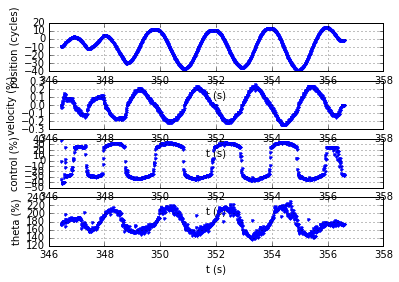

In [27]:
plt.subplot(4,1,1)
plt.plot(t, 360*position, '.')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

plt.subplot(4,1,2)
plt.plot(t, velocity, '.')
plt.xlabel('t (s)')
plt.ylabel('velocity (%)')
plt.grid()

plt.subplot(4,1,3)
plt.plot(t, control, '.')
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()

plt.subplot(4,1,4)
plt.plot(t, 360*theta, '.')
plt.xlabel('t (s)')
plt.ylabel('theta (%)')
plt.grid()

#Control Up PID

In [23]:
pmax = 1
Kp = 3*100
Kd = 0.02*100
Ki = 0*100


try:
    controller.remove_filter('controller1')
except:
    pass
controller.add_filter('controller1', 
                      Feedback(gamma = pmax,
                               block = TransferFunction(model = PID(Kp = Kp, Kd = Kd, Ki = Ki, period = controller.period))),
                      ['theta', 'reference1'], 
                      ['deadzoneinverse'])
print(controller.info('all'))

> Controller with 7 signal(s), 4 source(s), 2 sink(s), and 2 filter(s)
> period = 0.01s
> signals
  1. encoder1
  2. clock
  3. pot1
  4. motor1
  5. reference1
  6. theta
  7. deadzoneinverse
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. pot1[enabled] >> pot1
  4. theta[enabled] >> theta
> filters
  1. deadzoneinverse >> deadzoneinverse[enabled] >> motor1
  2. theta, reference1 >> controller1[enabled] >> deadzoneinverse
> sinks
  1. motor1 >> motor1[disabled]
  2. clock, encoder1, motor1, reference1, theta >> logger[enabled]



In [24]:
preference = 0.75*100
controller.set_sink('logger','reset')
#controller.write_source('encoder1',[0,])
with controller:
    controller.set_signal('reference1',preference)
    time.sleep(5)
log = controller.read_sink('logger')

In [22]:
t = log[:,0]
position = log[:,1]
control = log[:,2]
reference = log[:,3]
theta = log[:,4]

print(np.mean(theta))

velocity = np.zeros(t.shape, float)
velocity[1:] = (position[1:]-position[:-1])/(t[1:]-t[:-1])

0.755156296678


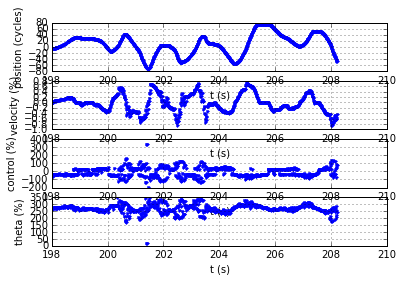

In [23]:
plt.subplot(4,1,1)
plt.plot(t, 360*position, '.')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

plt.subplot(4,1,2)
plt.plot(t, velocity, '.')
plt.xlabel('t (s)')
plt.ylabel('velocity (%)')
plt.grid()

plt.subplot(4,1,3)
plt.plot(t, control, '.')
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()

plt.subplot(4,1,4)
plt.plot(t, 360*theta, '.')
plt.xlabel('t (s)')
plt.ylabel('theta (%)')
plt.grid()

In [9]:
control2 = control.copy()
ind = np.where((control2 > -umin) & (control2 < umin))
print(ind[0].shape, control2.shape)
control2[ind] = 0
ind = np.where(control2 > umin)
control2[ind] = control2[ind] - umin
ind = np.where(control < -umin)
control2[ind] = control2[ind] + umin

In [11]:
plt.plot(t, control2, 'b.', t, 100*position, 'r.')
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()
plt.xlim(2,7)

a = 0.019, v0 = 16.613
